In [1]:
'''
Copyright

Jelen forráskód a Budapesti Műszaki és Gazdaságtudományi Egyetemen tartott
"Deep Learning a gyakorlatban Python és LUA alapon" tantárgy segédanyagaként készült.

A tantárgy honlapja: http://smartlab.tmit.bme.hu/oktatas-deep-learning
Deep Learning kutatás: http://smartlab.tmit.bme.hu/deep-learning

A forráskódot GPLv3 licensz védi. Újrafelhasználás esetén lehetőség szerint kérjük
az alábbi szerzőt értesíteni.

2016 (c) Csapó Tamás Gábor (csapot kukac tmit pont bme pont hu)

Original Variational AutoEncoder example from:
Links:
    [MNIST Dataset] http://yann.lecun.com/exdb/mnist/
    [VAE] https://jmetzen.github.io/2015-11-27/vae.html
'''

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
# %matplotlib inline

from VAE import VariationalAutoencoder

np.random.seed(0)
tf.set_random_seed(0)

# MNIST adatok betöltése
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)
n_samples = mnist.train.num_examples


def train(network_architecture, learning_rate=0.001,
          batch_size=100, training_epochs=10, display_step=5):
    
    vae = VariationalAutoencoder(network_architecture, 
                                 learning_rate=learning_rate, 
                                 batch_size=batch_size)
    total_batch = int(n_samples / batch_size)
    
    # tanítási ciklus
    for epoch in range(training_epochs):
        avg_cost = 0.        
        # batch-ek
        for i in range(total_batch):
            batch_xs, _ = mnist.train.next_batch(batch_size)

            # tanítási lépés
            cost = vae.partial_fit(batch_xs)
            
            # hiba számítás
            avg_cost += cost / n_samples * batch_size

        # adott epoch után log kiírása
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), \
                  "cost=", "{:.9f}".format(avg_cost))
    return vae




Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


Epoch: 0001 cost= 181.718630621
Epoch: 0006 cost= 109.408282582
Epoch: 0011 cost= 104.003689839
Epoch: 0016 cost= 101.470421434
Epoch: 0021 cost= 100.067715066
Epoch: 0026 cost= 99.081331094
Epoch: 0031 cost= 98.370135831
Epoch: 0036 cost= 97.749072696
Epoch: 0041 cost= 97.252559745
Epoch: 0046 cost= 96.861993367


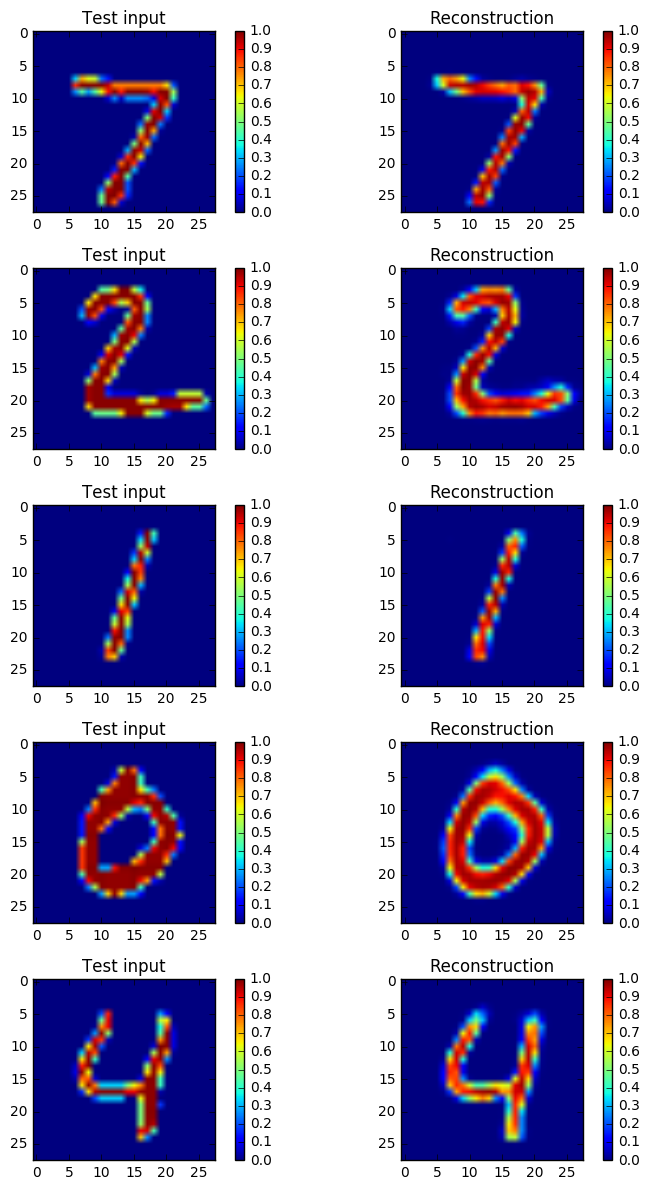

In [2]:
### VAE tanítás, 20D látens tér

network_architecture = \
    dict(n_hidden_recog_1=500, # 1. réteg encoder neuronok
         n_hidden_recog_2=300, # 2. réteg encoder neuronok
         n_hidden_gener_1=300, # 1. réteg decoder neuronok
         n_hidden_gener_2=500, # 2. réteg decoder neuronok
         n_input=784,          # MNIST bemenet (img shape: 28*28)
         n_z=20)               # látens tér dimenziója

vae = train(network_architecture, training_epochs=50)

# visszaállított adatok megjelenítése
x_sample = mnist.test.next_batch(100)[0]
x_reconstruct = vae.reconstruct(x_sample)
plt.figure(figsize=(8, 12))
for i in range(5):
    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1)
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(x_reconstruct[i].reshape(28, 28), vmin=0, vmax=1)
    plt.title("Reconstruction")
    plt.colorbar()
plt.tight_layout()
plt.show()

In [3]:
### VAE tanítás, 2D látens sík
# Gauess eloszlás összenyomása a látens térbe, az átlag közelébe

network_architecture = \
    dict(n_hidden_recog_1=500, # 1. réteg encoder neuronok
         n_hidden_recog_2=300, # 2. réteg encoder neuronok
         n_hidden_gener_1=300, # 1. réteg decoder neuronok
         n_hidden_gener_2=500, # 2. réteg decoder neuronok
         n_input=784,          # MNIST bemenet (img shape: 28*28)
         n_z=2)                # látens tér dimenziója

vae_2d = train(network_architecture, training_epochs=50)

Epoch: 0001 cost= 189.910893555
Epoch: 0006 cost= 153.638912243
Epoch: 0011 cost= 148.373512129
Epoch: 0016 cost= 145.835008434
Epoch: 0021 cost= 144.202075778
Epoch: 0026 cost= 143.070692055
Epoch: 0031 cost= 142.146318984
Epoch: 0036 cost= 141.424038419
Epoch: 0041 cost= 140.841092515
Epoch: 0046 cost= 140.390517939


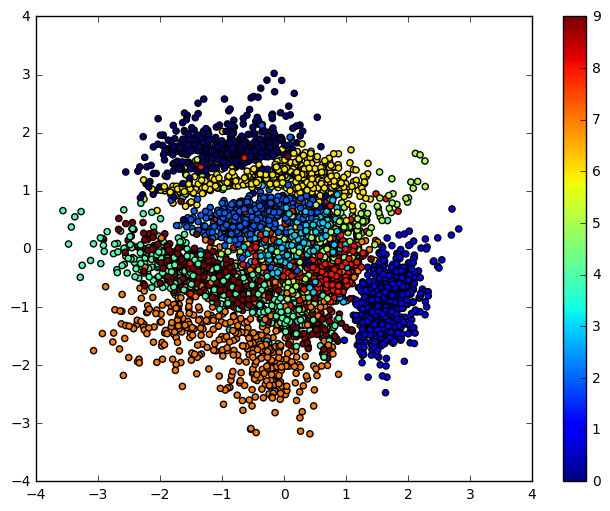

In [4]:
# 2D látens sík megjelenítése

x_sample, y_sample = mnist.test.next_batch(5000)
# VAE.transform: adat transzformálása a látens térbe
z_mu = vae_2d.transform(x_sample)
plt.figure(figsize=(8, 6)) 
plt.scatter(z_mu[:, 0], z_mu[:, 1], c=np.argmax(y_sample, 1))
plt.colorbar()
plt.show()

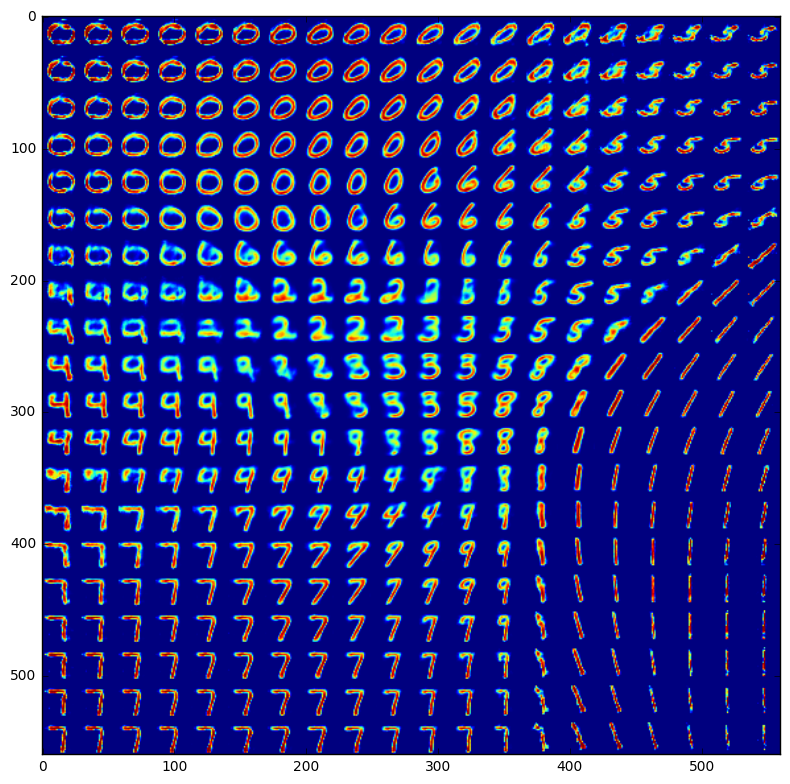

In [5]:
# generáló hálózattal visszaállítunk 20x20 db képet, 
# és a látens tér megfelelő helyén ábrázoljuk azokat
nx = ny = 20
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)

# képek rárajzolása a 2D látens síkra
canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        # bug a VAE forráskódjában, ezért fura méretű z_mu kell
        z_mu = np.zeros((100, 2))
        z_mu[0,0] = xi
        z_mu[0,1] = yi
        # VAE.generate: adat generálása a látens térből történő mintavételezéssel
        x_mean = vae_2d.generate(z_mu)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

# ábra kirajzolása
plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper")
plt.tight_layout()
plt.show()